In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4
np.random.seed(1234)

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

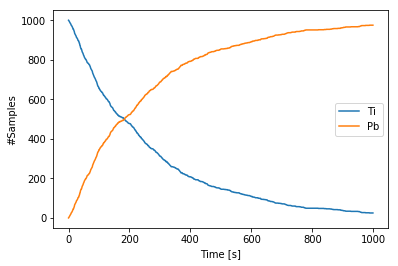

In [2]:
# First Point

samples = 1000
ti = np.ones(samples)
ti_hist = np.array(ti.shape)
pb_hist = np.array([0])
tau = 3.052*60 # half-life [s]
elapsed_time = 1000

decay_prob = 1.-2**(-1/tau)

for t in range(1,elapsed_time):
    cond = [np.random.uniform(size=ti.size)>=decay_prob]
    ti   = np.extract(cond,ti)
    ti_hist = np.append(ti_hist,ti.size)
    pb_hist = np.append(pb_hist,samples - ti.size)

# Plot
plt.plot(ti_hist,label='Ti')
plt.plot(pb_hist,label='Pb')
plt.legend()

plt.xlabel('Time [s]')
plt.ylabel('#Samples')
plt.show()

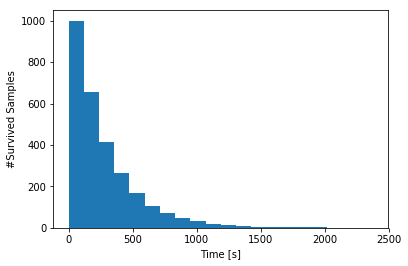

In [3]:
#Second Point

#decay_times = np.random.exponential(tau/np.log(2),size=samples)
#np.histogram(decay_times,bins=10)

def expon_icdf(p, mu=np.log(2)/tau):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log(1-p)/mu

decay_times = expon_icdf(np.random.random(samples))
plt.hist(decay_times,bins=20, cumulative=-1)
plt.xlabel('Time [s]')
plt.ylabel('#Survived Samples')
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [4]:
n = 1000000 # 1 mln alpha part
b = np.random.normal(scale=52.9*10**-(12+2),size=n) # Bohr radius/100
cost  = np.array((79*1.6*10**-19) / (2*np.pi*8.85*10**-12*7.7*10**6)) # as np.array to overcome %precision 4
theta = 2*np.arctan(cost/b)
bounce_backs = theta[theta>np.pi/2]
print("Particle fraction whose scattering angle is greater than pi/2: ",bounce_backs.size / n)

Particle fraction whose scattering angle is greater than pi/2:  0.022234


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

Result from Mathematica:  1.45140148539
Integral Estimate - Hit or Miss:  1.44798
Error:  0.0034214853899998676
Integral Estimate - Mean value:  1.44798
Error:  0.001223985982031106


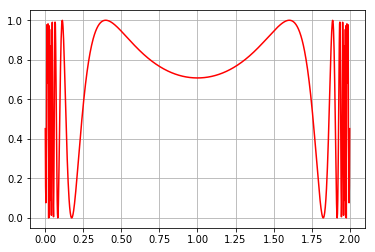

In [5]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(0.001,1.999,1000)
plt.plot(x,f(x),'r-')
plt.grid()

#result from Mathematica
mathem = 1.451401485390
print("Result from Mathematica: ",mathem)

# Monte Carlo integration - Hit or Miss
N=100000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=2*count/N
print("Integral Estimate - Hit or Miss: ",I)
print("Error: ",mathem - I)


# Monte Carlo integration - Mean value
summ = 0
for i in range(N):
    x=2*np.random.random()
    summ += f(x)
I2 = 2*summ/N
print("Integral Estimate - Mean value: ",I)
print("Error: ",mathem - I2)

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [6]:
def func_sphere(var): # Call function with 1D np.array of variables
    if np.sum(var**2) <= 1: return 1
    else: return 0

def int_sphere(d=2,N=100000):
    x     = 2*np.random.random(size=(N,d)) - 1  # draw from [-1,1] in each dimension
    count = 0
    for i in range(N):
        if func_sphere(x[i,:]) == 1: count += 1 # select points in the sphere
    return (2**d) * count / N # taking into account multidimensional volume of the box

from scipy.special import gamma
def volume_nball(n=2):
    """https://en.wikipedia.org/wiki/Volume_of_an_n-ball"""
    return (np.pi**(n/2.))/(gamma(1+n/2))

np.random.seed(1234)
circle = int_sphere()
print("Exact area of a unit radius circle: ", volume_nball(2))
print("Estimated Integral: ",circle)
print("Error: ",circle - volume_nball(2))

print("\n")

circle_10D = int_sphere(d=10, N=1000000) # in higher dimensions, more points and integration time are required
print("Exact area of a unit radius 10D sphere: ", volume_nball(10))
print("Estimanted Integral of a 10D sphere: ", circle_10D)
print("Erorr: ",circle_10D - volume_nball(10))

Exact area of a unit radius circle:  3.141592653589793
Estimated Integral:  3.13892
Error:  -0.0026726535897929615


Exact area of a unit radius 10D sphere:  2.550164039877345
Estimanted Integral of a 10D sphere:  2.609152
Erorr:  0.05898796012265484


(764, 2)


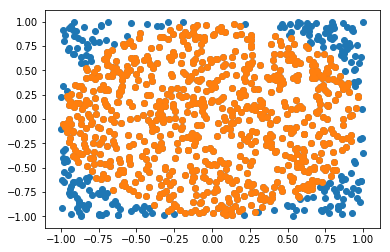

In [7]:
# Debug and plot of 2D case
np.random.seed(1234)
x=2*np.random.random(size=(1000,2)) - 1
plt.scatter(x[:,0],x[:,1])
circ = np.array([x[i,:] for i in range(1000) if func_sphere(x[i,:]) == 1])
plt.scatter(circ[:,0],circ[:,1])
print(circ.shape)

5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

Estimated Integral:  0.8481367090046713


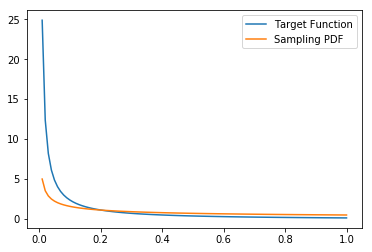

In [8]:
def func(x):
    return (x**-1/2)/(np.exp(x)+1)

def weight(x):
    return 1./(2*np.sqrt(x)) # 2 has been added to normalize the function in (0,1), s.t. it's an effective PDF

# Plots
x = np.linspace(0.01,1,100)
plt.plot(x,func(x),label="Target Function")
plt.plot(x,weight(x),label="Sampling PDF")
plt.legend()
plt.plot()

# Importance Sampling integral
n = 10000
unif = np.random.random(size=n) # arbitray distribution to get random variates of the domain (0,1) 
I = 1.0 / n * np.sum(func(unif) / weight(unif))
print("Estimated Integral: ",I)